<a href="https://colab.research.google.com/github/rabihchamas/Grad-Cam-Pytorch/blob/main/Grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


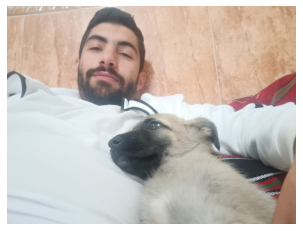

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image


transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# Open the image using Pillow
#dataset = datasets.ImageFolder(root='/content/drive/MyDrive/21056023_10155010921277153_2976628059067270286_o.jpg', transform=transform)
img = Image.open('/content/drive/MyDrive/WhatsApp Image 2023-03-04 at 11.50.25.jpeg')
#image = Image.open('/content/gdrive/MyDrive/path/to/image.jpg')
image_tensor = transform(img)
#dataset = datasets.DatasetFolder(root='/content/drive/MyDrive', loader=lambda x: image_tensor, extensions=('jpg',))
#dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)
# Plot the image using Matplotlib
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
print(image_tensor.shape)

torch.Size([3, 224, 224])


In [ ]:


# # use the ImageNet transformation
# transform = transforms.Compose([transforms.Resize((224, 224)), 
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# # define a 1 image dataset
# dataset = datasets.ImageFolder(root='/content/drive/MyDrive/new pics', transform=transform)

# # define the dataloader to load that single image
# dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [ ]:
vgg19(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the most likely prediction of the model
x = vgg(image_tensor).argmax(dim=1)
pred = vgg(image_tensor)

In [ ]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 257].backward()

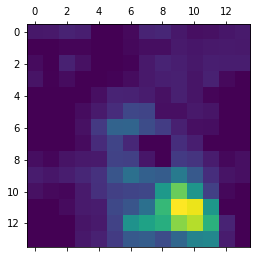

In [ ]:



# pull the gradients out of the model
gradients = vgg.get_activations_gradient()
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[1,2])
# get the activations of the last convolutional layer
activations = vgg.get_activations(image_tensor).detach()
# weight the channels by corresponding gradients
for i in range(512):
    activations[ i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=0).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [ ]:
import cv2
img = cv2.imread('/content/drive/MyDrive/WhatsApp Image 2023-03-04 at 11.50.25.jpeg')
img = cv2.resize(img,(224,224))
heatmap=heatmap.numpy()
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * heatmap)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# superimposed_img = heatmap * 0.4 + img
heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.4, heatmap, 0.6, 0)

#cv2.imwrite('./map.jpg', superimposed_img)

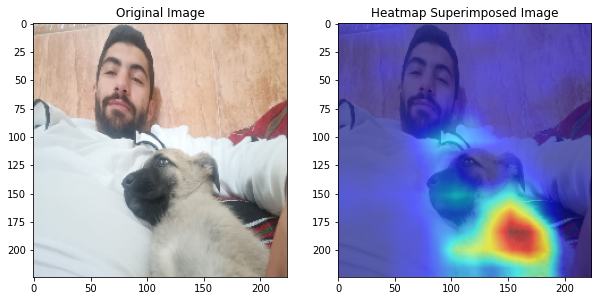

In [ ]:
# Display the original image and the resulting image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
#ax[1].imshow(superimposed_img)
ax[1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
ax[1].set_title('Heatmap Superimposed Image')
plt.show()

In [ ]:
#cv2.imwrite('./map1.jpg', img)